In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import ineqpy
import seaborn as sns
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

DATA_dir = "data/"

In [22]:
def load_data(experiment, var1, var2):
    
    samples = 71

    data_filenames = [f for f in listdir(DATA_dir) if isfile(join(DATA_dir, f))]
    data_filenames = [f for f in data_filenames if f.startswith(f"{experiment}")]

#     print(len(data_filenames))#, "files found:", data_filenames)
    
    df_concat_list = []
    run = 0
    groups = []
    grouplens = []
    
    print(len(data_filenames), "To load, files loaded: ", end="")
    for i, data_filename in enumerate(data_filenames):
        df = pd.read_csv(DATA_dir + data_filename)
        df.insert(0, "Run", run)
        run += 1
        
        df.columns = df.columns.str.replace(' ', '')
        df["Group"] = var1 + df[var1].astype(str) + var2 + df[var2].astype(str)
        
        if df["Group"][0] not in groups:
            groups.append(df["Group"][0])
            grouplens.append(1)
        else:
            group_index = groups.index(df["Group"][0])
            grouplens[group_index] += 1
        
        group_index = groups.index(df["Group"][0])
                                   
        
        if grouplens[group_index] < samples:

            for step in set(df["Step"].tolist()):
                wealth = np.array( df.loc[(df.Step == step)]["Wealth"].tolist() )
                gini = ineqpy.gini(np.array(wealth))
                df.loc[(df.Step == step), "Gini"] = gini

            df_concat_list.append(df)

        print(i, end=" ")

    data_raw = pd.concat(df_concat_list)
    del df_concat_list
    del run
    
    data = data_raw.loc[(data_raw.Step >= 199)].groupby(["Run", "Group"]).mean().reset_index()
    # data = data[["Run", "Step", "Gini"]]
    return data


def twofactanalysis(df, var1, var2):

    var1vals = list(set(df[var1].tolist()))
    var2vals = list(set(df[var2].tolist()))



    group_names = []
    data_temp = []
    for var1value in var1vals:
        for var2value in var2vals:
            ginis = df.loc[(df[var1] == var1value) & (df[var2] == var2value)]["Gini"].tolist()
            data_temp.append(ginis)
            group_names.append(f"{var1} {var1value} {var2} {var2value}")

    data_temp = np.array(data_temp)
    
#     print(data_temp.shape)
    for dat in data_temp:
        print(len(dat), end=" ")
    print("")

    for i, group in enumerate(data_temp):
        print(group_names[i])
        print("mean: ", np.mean(group))
        print("sd:   ", np.std(group))
        print("Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):\np =", stats.kstest(group, 'norm')[1])
        print("\n")

    if len(data_temp) == 6:
        print("Levene test (equal variances, p>0.05 is equal var)\np =", stats.levene(data_temp[0], data_temp[1], data_temp[2], data_temp[3], data_temp[4], data_temp[5])[1])
    if len(data_temp) == 4:
        print("Levene test (equal variances, p>0.05 is equal var)\np =", stats.levene(data_temp[0], data_temp[1], data_temp[2], data_temp[3])[1])
    if len(data_temp) == 10:
        print("Levene test (equal variances, p>0.05 is equal var)\np =", stats.levene(data_temp[0], data_temp[1], data_temp[2], data_temp[3], data_temp[4], data_temp[5], data_temp[6], data_temp[7], data_temp[8], data_temp[9])[1])

    # two way ANOVA
    print("\nTwo-way ANOVA, don't forget to check normality and equality:")
    model = ols(f'Gini ~ C({var1}) + C({var2}) + C({var1}):C({var2})', data=df).fit()
    twowayresults = sm.stats.anova_lm(model, typ=2)
    print(twowayresults)

    print("\n Pairwise Tukey if ANOVA significant:")
    tukey = pairwise_tukeyhsd(endog=df['Gini'],
                              groups=df["Group"],
                              alpha=0.05)
    print(tukey)

# test data

In [5]:
testdata = load_data("test", "TaxRate", "Amsmap")
testdata

18 To load, files loaded: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 

,Run,Group,Step,Wealth,Vision,TaxRate,Amsmap,Death,Instregrowth,Gini
0,0,TaxRate0.0AmsmapFalse,224,107839.200000,6,0.00,False,True,False,0.505501
1,1,TaxRate0.5AmsmapFalse,224,137838.078431,6,0.50,False,True,False,0.404616
2,2,TaxRate0.5AmsmapTrue,224,7459.286275,6,0.50,True,True,False,0.613689
3,3,TaxRate0.5AmsmapTrue,224,3171.952941,6,0.50,True,True,False,0.401318
4,4,TaxRate0.0AmsmapTrue,224,9929.743137,6,0.00,True,True,False,0.718052
5,5,TaxRate0.25AmsmapTrue,224,3051.490196,6,0.25,True,True,False,0.459154
6,6,TaxRate0.25AmsmapTrue,224,12149.554902,6,0.25,True,True,False,0.859826
7,7,TaxRate0.25AmsmapFalse,224,80880.515686,6,0.25,False,True,False,0.616980
8,8,TaxRate0.0AmsmapFalse,224,116961.490196,6,0.00,False,True,False,0.489524
9,9,TaxRate0.0AmsmapFalse,224,119859.066667,6,0.00,False,True,False,0.666011


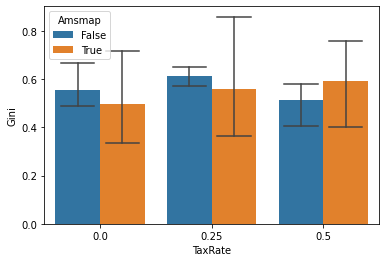

In [6]:
ax = sns.barplot(x="TaxRate", y="Gini", hue="Amsmap", data=testdata, ci=95, n_boot=10000, errwidth=1.5, capsize=0.3)

# Taxation

In [23]:
taxation = load_data("taxation", "Amsmap", "TaxRate")
taxation

700 To load, files loaded: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270

,Run,Group,Step,Wealth,Vision,TaxRate,Amsmap,Death,Instregrowth,Gini
0,0,AmsmapFalseTaxRate0.0,224,80800.896941,6,0.00,False,True,False,0.121364
1,1,AmsmapTrueTaxRate0.0,224,79772.428392,6,0.00,True,True,False,0.283983
2,2,AmsmapFalseTaxRate0.25,224,37494.685217,6,0.25,False,True,False,0.137959
3,3,AmsmapFalseTaxRate0.0,224,80801.722039,6,0.00,False,True,False,0.114178
4,4,AmsmapTrueTaxRate0.25,224,36762.168727,6,0.25,True,True,False,0.260799
...,...,...,...,...,...,...,...,...,...,...
695,695,AmsmapFalseTaxRate0.5,224,13338.004681,6,0.50,False,True,False,0.187658
696,696,AmsmapFalseTaxRate1.0,224,293.573020,6,1.00,False,True,False,0.334700
697,697,AmsmapTrueTaxRate0.75,224,2236.435125,6,0.75,True,True,False,0.369645
698,698,AmsmapTrueTaxRate0.5,224,12648.820863,6,0.50,True,True,False,0.348112


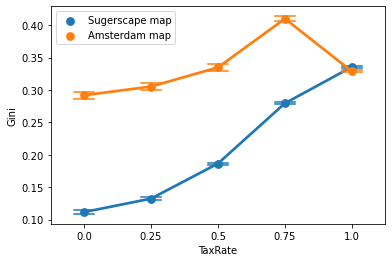

In [24]:
ax = sns.pointplot(x="TaxRate", y="Gini", hue="Amsmap", data=taxation, ci=95, n_boot=10000, errwidth=1.5, capsize=0.3)

L = plt.legend()
L.get_texts()[0].set_text('Sugerscape map')
L.get_texts()[1].set_text('Amsterdam map')
plt.show()

In [25]:
twofactanalysis(taxation, "TaxRate", "Amsmap")

70 70 70 70 70 70 70 70 70 70 
TaxRate 0.0 Amsmap False
mean:  0.11148647258251539
sd:    0.012152441007725117
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 3.0584612596523584e-19


TaxRate 0.0 Amsmap True
mean:  0.2918870273097811
sd:    0.021513622012902564
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 3.3397360110869884e-24


TaxRate 0.25 Amsmap False
mean:  0.13224975067818182
sd:    0.009823037845259692
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 7.226748131939743e-20


TaxRate 0.25 Amsmap True
mean:  0.30529780794469824
sd:    0.02232354978136787
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 6.913995907581309e-25


TaxRate 0.75 Amsmap False
mean:  0.2794699074464135
sd:    0.007783524443925522
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 6.958246612598247e-25


TaxRate 0.75 Amsmap True
mean:  0.40999794305209475
sd:    0.016696592696102207
Kolmogorov-Smirnov (normality assumption, p<

# vision

In [8]:
vision = load_data("vision", "Amsmap", "Vision")
vision

466 To load, files loaded: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270

,Run,Group,Step,Wealth,Vision,TaxRate,Amsmap,Death,Instregrowth,Gini
0,0,AmsmapFalseVision2,224,296.205961,2,1,False,True,False,0.340598
1,1,AmsmapTrueVision2,224,101.767686,2,1,True,True,False,0.375846
2,2,AmsmapFalseVision6,224,306.100314,6,1,False,True,False,0.322172
3,3,AmsmapTrueVision6,224,99.814196,6,1,True,True,False,0.343068
4,4,AmsmapFalseVision10,224,290.995137,10,1,False,True,False,0.340090
...,...,...,...,...,...,...,...,...,...,...
415,415,AmsmapFalseVision2,224,296.689098,2,1,False,True,False,0.345496
416,416,AmsmapFalseVision6,224,305.861569,6,1,False,True,False,0.317966
417,417,AmsmapTrueVision6,224,97.954980,6,1,True,True,False,0.343545
418,418,AmsmapFalseVision10,224,281.223451,10,1,False,True,False,0.341899


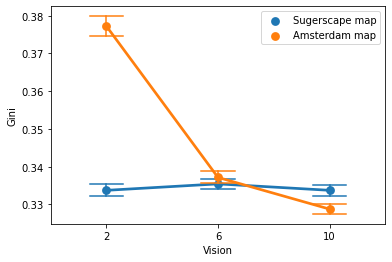

In [11]:
ax = sns.pointplot(x="Vision", y="Gini", hue="Amsmap", data=vision, ci=95, n_boot=10000, errwidth=1.5, capsize=0.3)
L = plt.legend()
L.get_texts()[0].set_text('Sugerscape map')
L.get_texts()[1].set_text('Amsterdam map')
plt.show()

In [13]:
twofactanalysis(vision, "Vision", "Amsmap")

70 70 70 70 70 70 
Vision 2 Amsmap False
mean:  0.33374970687095834
sd:    0.006901693635435031
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 8.437075449706494e-27


Vision 2 Amsmap True
mean:  0.3772543574457301
sd:    0.011268370459130518
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 4.870071789448694e-28


Vision 10 Amsmap False
mean:  0.33375324590232863
sd:    0.006486962131066416
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 6.92595224526342e-27


Vision 10 Amsmap True
mean:  0.3287760278639536
sd:    0.005368858514396225
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 1.1836814602593613e-26


Vision 6 Amsmap False
mean:  0.33545543667819844
sd:    0.005989653721559314
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 6.3717892663274574e-27


Vision 6 Amsmap True
mean:  0.33716604709022757
sd:    0.0065002949953878305
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 3.53478490

# death

In [9]:
death = load_data("death", "Amsmap", "Death")
death

280 To load, files loaded: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270

,Run,Group,Step,Wealth,Vision,TaxRate,Amsmap,Death,Instregrowth,Gini
0,0,AmsmapFalseDeathTrue,224,300.232471,6,1,False,True,False,0.329089
1,1,AmsmapTrueDeathTrue,224,99.891843,6,1,True,True,False,0.333065
2,2,AmsmapFalseDeathFalse,224,79623.868863,6,1,False,False,False,0.143004
3,3,AmsmapTrueDeathFalse,224,79761.388000,6,1,True,False,False,0.301985
4,4,AmsmapFalseDeathTrue,224,284.676392,6,1,False,True,False,0.347934
...,...,...,...,...,...,...,...,...,...,...
275,275,AmsmapTrueDeathFalse,224,79760.885255,6,1,True,False,False,0.306739
276,276,AmsmapFalseDeathTrue,224,288.036784,6,1,False,True,False,0.343710
277,277,AmsmapTrueDeathTrue,224,100.137098,6,1,True,True,False,0.330763
278,278,AmsmapFalseDeathFalse,224,80061.450118,6,1,False,False,False,0.109166


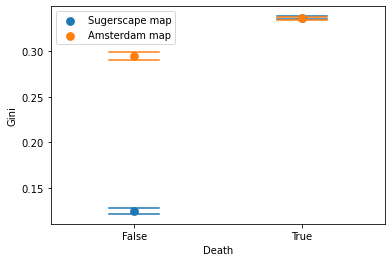

In [18]:
ax = sns.pointplot(x="Death", y="Gini", hue="Amsmap", data=death, ci=95, n_boot=10000, errwidth=1.5, capsize=0.3, join=False)

L = plt.legend()
L.get_texts()[0].set_text('Sugerscape map')
L.get_texts()[1].set_text('Amsterdam map')
plt.show()

In [15]:
twofactanalysis(death, "Death", "Amsmap")

70 70 70 70 
Death False Amsmap False
mean:  0.12453808549229746
sd:    0.013211859192745753
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 1.4367640164510012e-19


Death False Amsmap True
mean:  0.29445038798913475
sd:    0.017889650004021672
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 2.3387264420923567e-24


Death True Amsmap False
mean:  0.3367762255499238
sd:    0.006594173426114493
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 4.842420448019783e-27


Death True Amsmap True
mean:  0.33601204556830083
sd:    0.006653202135406076
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 4.661873464968265e-27


Levene test (equal variances, p>0.05 is equal var)
p = 7.515154022707204e-13

Two-way ANOVA, don't forget to check normality and equality:
                      sum_sq     df            F         PR(>F)
C(Death)            1.127251    1.0  7632.279199  3.970889e-203
C(Amsmap)           0.500694    1.0  3390.04973

# insregrow

In [10]:
insregrow = load_data("insregrow", "Amsmap", "Instregrowth")
insregrow

280 To load, files loaded: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270

,Run,Group,Step,Wealth,Vision,TaxRate,Amsmap,Death,Instregrowth,Gini
0,0,AmsmapFalseInstregrowthTrue,224,6.419668e+05,6,1,False,True,True,0.353658
1,1,AmsmapTrueInstregrowthTrue,224,1.632917e+06,6,1,True,True,True,0.386991
2,2,AmsmapFalseInstregrowthFalse,224,2.882010e+02,6,1,False,True,False,0.337738
3,3,AmsmapTrueInstregrowthFalse,224,9.949427e+01,6,1,True,True,False,0.343114
4,4,AmsmapFalseInstregrowthTrue,224,6.542021e+05,6,1,False,True,True,0.344416
...,...,...,...,...,...,...,...,...,...,...
275,275,AmsmapTrueInstregrowthFalse,224,9.819247e+01,6,1,True,True,False,0.339816
276,276,AmsmapFalseInstregrowthTrue,224,6.374717e+05,6,1,False,True,True,0.352362
277,277,AmsmapTrueInstregrowthTrue,224,1.614182e+06,6,1,True,True,True,0.393534
278,278,AmsmapFalseInstregrowthFalse,224,3.007395e+02,6,1,False,True,False,0.322448


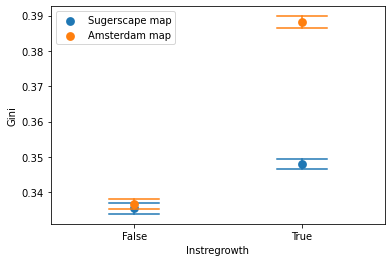

In [19]:
ax = sns.pointplot(x="Instregrowth", y="Gini", hue="Amsmap", data=insregrow, ci=95, n_boot=10000, errwidth=1.5, capsize=0.3, join=False)

L = plt.legend()
L.get_texts()[0].set_text('Sugerscape map')
L.get_texts()[1].set_text('Amsterdam map')
plt.show()

In [17]:
twofactanalysis(insregrow, "Instregrowth", "Amsmap")

70 70 70 70 
Instregrowth False Amsmap False
mean:  0.3354262089829809
sd:    0.006872263324442792
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 9.205999919030025e-27


Instregrowth False Amsmap True
mean:  0.3366152204082294
sd:    0.006464975636358218
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 4.121283351104185e-27


Instregrowth True Amsmap False
mean:  0.3480275551742571
sd:    0.005883643296107227
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 1.4450494755934557e-27


Instregrowth True Amsmap True
mean:  0.3881333602852708
sd:    0.007389479403126896
Kolmogorov-Smirnov (normality assumption, p<0.05 is normal):
p = 8.392488686097671e-29


Levene test (equal variances, p>0.05 is equal var)
p = 0.5789182367394429

Two-way ANOVA, don't forget to check normality and equality:
                             sum_sq     df            F         PR(>F)
C(Instregrowth)            0.071948    1.0  1591.513742  1.338432e-116
C(Amsmap)   

In [ ]:
# def pltSD(nparray):
#     """
#     Plots the SD of a given array using fill_between from matplotlib to the plt
#     """
#     try:
#         means = np.mean(nparray, axis=0)
#         stds = np.std(nparray, axis=0)
#         plt.fill_between(list(range(len(means))), [means[i] - stds[i] for i, val in enumerate(means)], [means[i] + stds[i] for i, val in enumerate(means)], alpha = 0.25)
#     except:
#         pass
#     return

In [ ]:
# gini_overtime = np.array(data.loc[(data.Run == 0)]["Gini"].tolist())
# runs = max(data["Run"].tolist())
# for run in range(1, runs + 1):
#      gini_overtime = np.vstack((gini_overtime, np.array(data.loc[(data.Run == run)]["Gini"].tolist())))

# plt.plot(np.mean(gini_overtime, axis=0))
# pltSD(gini_overtime)
# plt.xlabel("Time")
# plt.ylabel("Gini")
# plt.show()